# Gaussian Process Auto-Regressive Model (GPAR)

The GPAR model is formed by assuming a "closed downward" dependence structure for the data, i.e. if $(x, y_i) \in D$ that $(x, y_j) \in D$ for all $j \le i$. We then write the joint as a factored model,

$$
p(y_1, \ldots, y_n) = p(y_1) p(y_2 | y_1) \ldots p(y_n | y_{n-1}, y_{n-2}, \ldots, y_1)
$$
where each $y_i$ is assumed to be a Gaussian process, and given noise variances $\sigma_i^2$. The input to each GP is are the coordinates and the posterior mean of all preceding dimensions.


In [1]:
# For Gaussian processes 64bit is important
from jax.config import config

config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp
from functools import cached_property
from typing import Tuple, Dict, NamedTuple

from jax import tree_map
from jax import random
from jax import numpy as jnp
from jax.scipy.linalg import solve_triangular

import pylab as plt

from jaxns.types import float_type
from jaxns.prior import PriorModelGen
from jaxns import Prior, Model, TerminationCondition, ApproximateNestedSampler
from jaxns import maximum_a_posteriori_point, evaluate_map_estimate

tfpd = tfp.distributions
tfpk = tfp.math.psd_kernels

INFO[2023-09-25 00:15:50,395]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-09-25 00:15:50,396]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-09-25 00:15:50,398]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2023-09-25 00:15:50,398]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


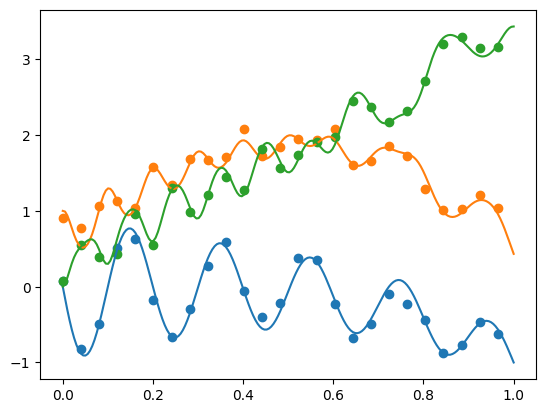

In [2]:
# Create toy data set.
n = 200
x = jnp.linspace(0, 1, n)
noise = 0.1

# Draw functions depending on each other in complicated ways.
f1 = -jnp.sin(10 * jnp.pi * (x + 1)) / (2 * x + 1) - x ** 4
f2 = jnp.cos(f1) ** 2 + jnp.sin(3 * x)
f3 = f2 * f1 ** 2 + 3 * x
f = jnp.stack((f1, f2, f3), axis=1)

# Add noise and subsample.
y = f + noise * random.normal(random.PRNGKey(42), shape=(n, 3))
x_obs, y_obs = x[::8], y[::8]

for i in range(3):
    plt.plot(x, f[:, i], label='f{}'.format(i))
    plt.scatter(x_obs, y_obs[:, i], label='y{}'.format(i))

plt.show()


In [3]:



def log_normal_with_mask(x, mean, cov, sigma):
    """
    Computes log-Normal density in a numerically stable way so that sigma can contain +inf for masked data.

    Args:
        x: RV value
        mean: mean of Gaussian
        cov: covariance of underlying, minus the obs. covariance
        sigma: stddev's of obs. error, inf encodes an outlier.

    Returns: a normal density for all points not of inf stddev obs. error.
    """
    C = cov / (sigma[:, None] * sigma[None, :]) + jnp.eye(cov.shape[0])
    L = jnp.linalg.cholesky(C)
    Ls = sigma[:, None] * L
    log_det = jnp.sum(jnp.where(jnp.isinf(sigma), 0., jnp.log(jnp.diag(Ls))))
    dx = (x - mean)
    dx = solve_triangular(L, dx / sigma, lower=True)
    maha = dx @ dx
    log_likelihood = -0.5 * jnp.sum(~jnp.isinf(sigma)) * jnp.log(2. * jnp.pi) \
                     - log_det \
                     - 0.5 * maha
    return log_likelihood


class GaussianProcessData(NamedTuple):
    X: jnp.ndarray
    Y: jnp.ndarray
    Y_var: jnp.ndarray
    sample_size: jnp.ndarray


def _assert_rank(rank: int, **kwargs):
    for name, t in kwargs.items():
        if len(t.shape) != rank:
            raise ValueError(f"{name} shoue be rank {rank} got {t.shape}.")


def _assert_same_leading_dim(*args):
    n = set()
    for arg in args:
        n.add(arg.shape[0])
    if len(n) > 1:
        raise ValueError(f"Got mismatched leading dimensions: {n}")


def _ensure_gaussian_process_data(data: GaussianProcessData) -> GaussianProcessData:
    data = tree_map(lambda x: jnp.asarray(x, float_type), data)
    _assert_rank(2, U=data.X)
    _assert_rank(1, sample_size=data.sample_size, Y=data.Y, Y_var=data.Y_var)
    _assert_same_leading_dim(*data)
    if data.Y.shape[0] < 2:
        raise ValueError('Need more samples to form mean and variance of data.')
    return data


def marginal_likelihood_with_mask(kernel: tfp.math.psd_kernels.PositiveSemidefiniteKernel,
                                  data: GaussianProcessData,
                                  variance: jnp.ndarray,
                                  mean: jnp.ndarray) -> jnp.ndarray:
    Kxx = kernel.matrix(data.X, data.X)
    no_uncert_data = jnp.isnan(data.Y_var)

    variance = jnp.where(no_uncert_data,
                         variance + variance / data.sample_size,
                         data.Y_var + variance / data.sample_size)

    sigma = jnp.sqrt(jnp.maximum(1e-6, variance))
    return log_normal_with_mask(x=data.Y, mean=mean, cov=Kxx, sigma=sigma)


def posterior_with_mask(Xstar: jnp.ndarray,
                        kernel: tfp.math.psd_kernels.PositiveSemidefiniteKernel,
                        data: GaussianProcessData,
                        variance: jnp.ndarray,
                        mean: jnp.ndarray,
                        cov: bool = False) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Computes the posterior mean and variance of a Gaussian process, given the data, and a mask.

    Args:
        Xstar: The input coordinates [H, D]
        kernel: The kernel function.
        data: The data, where masked data has inf variance.
        variance: The variance of the posterior mean.
        mean: The posterior mean.
        cov: If True, return the full covariance matrix, otherwise return the diagonal.

    Returns:
        The posterior mean, and variance of the data
    """

    Kxx = kernel.matrix(data.X, data.X)
    Kxs = kernel.matrix(data.X, Xstar)
    Kss = kernel.matrix(Xstar, Xstar)

    no_uncert_data = jnp.isnan(data.Y_var)

    variance = jnp.where(no_uncert_data,
                         variance + variance / data.sample_size,
                         data.Y_var + variance / data.sample_size)
    std_dev = jnp.sqrt(jnp.maximum(1e-6, variance))

    L = jnp.linalg.cholesky(Kxx / (std_dev[:, None] * std_dev[None, :]) + jnp.eye(std_dev.size))
    # L = jnp.where(jnp.isnan(L), jnp.eye(L.shape[0])/sigma, L)

    J = solve_triangular(L, Kxs / std_dev[:, None],
                         lower=True)  # same J as below, but safely taking into account inf mask.

    post_cov_s = Kss - J.T @ J

    dY = data.Y - mean
    dX = solve_triangular(L, dY / std_dev, lower=True)
    post_mu_s = mean + J.T @ dX  # mu - J^T L^-1 dY = mu - J^T dX

    if cov:
        return post_mu_s, post_cov_s
    return post_mu_s, jnp.diag(post_cov_s)


In [4]:




from jaxns.prior import PriorModelType
from typing import List


class Normaliser:
    """
    Normalises data to zero mean and unit variance.
    """

    def __init__(self, X: jnp.ndarray, Y: jnp.ndarray, Y_var: jnp.ndarray):
        self.X = X
        self.Y = Y
        self.Y_var = Y_var

    @property
    def normalisation_params(self) -> Dict[str, jnp.ndarray]:
        """
        Computes the normalisation parameters for the data.

        Returns:
            A dictionary containing the normalisation parameters.
        """
        X_loc = jnp.nanmean(self.X, axis=0, keepdims=True)
        X_scale = jnp.nanstd(self.X, axis=0, keepdims=True)
        Y_loc = jnp.nanmean(self.Y, axis=0, keepdims=True)
        Y_scale = jnp.nanstd(self.Y, axis=0, keepdims=True)
        return dict(
            X_loc=X_loc,
            X_scale=X_scale,
            Y_loc=Y_loc,
            Y_scale=Y_scale
        )

    def normalise_X(self, X: jnp.ndarray):
        return (X - self.normalisation_params['X_loc']) / self.normalisation_params['X_scale']

    def normalise_Y(self, Y: jnp.ndarray):
        return (Y - self.normalisation_params['Y_loc']) / self.normalisation_params['Y_scale']

    def normalise_Y_var(self, Y_var: jnp.ndarray):
        return Y_var / jnp.square(self.normalisation_params['Y_scale'])

    def normalise_data(self, X: jnp.ndarray, Y: jnp.ndarray, Y_var: jnp.ndarray):
        return self.normalise_X(X), self.normalise_Y(Y), self.normalise_Y_var(Y_var)

    def unnormalise_X(self, X: jnp.ndarray):
        return X * self.normalisation_params['X_scale'] + self.normalisation_params['X_loc']

    def unnormalise_Y(self, Y: jnp.ndarray):
        return Y * self.normalisation_params['Y_scale'] + self.normalisation_params['Y_loc']

    def unnormalise_Y_var(self, Y_var: jnp.ndarray):
        return Y_var * jnp.square(self.normalisation_params['Y_scale'])

    def unnormlise_data(self, X: jnp.ndarray, Y: jnp.ndarray, Y_var: jnp.ndarray):
        return self.unnormalise_X(X), self.unnormalise_Y(Y), self.unnormalise_Y_var(Y_var)


class GPAR:
    def __init__(self, X: jnp.ndarray, Y: jnp.ndarray, Y_var: jnp.ndarray):
        """
        Gaussian Process Auto-Regressive Model (GPAR) for M-dimensional data.

        Args:
            X: The input coordinates [N, D]
            Y: The data values [N, M]
            Y_var: The variance of the data values [N, M]
        """
        self.X = X
        self.Y = Y
        self.Y_var = Y_var
        self.normaliser = Normaliser(X, Y, Y_var)

    @cached_property
    def model(self) -> Model:
        return Model(prior_model=self._build_prior_model(), log_likelihood=self._log_likelihood)

    def _build_prior_model(self) -> PriorModelType:
        # Assumes input data is normalised.

        def prior_model() -> PriorModelGen:
            uncerts = []
            kernel_params = []

            D = self.X.shape[1]

            for i in range(self.ndims):
                # The i-th kernel is over concat([X, posterior_mean[:, :i]], axis=1)
                num_preceding_dims = i + D
                uncert = yield Prior(tfpd.HalfNormal(0.2), name='uncert_{}'.format(i))  # [1]
                length_scale = yield Prior(tfpd.HalfNormal(jnp.ones((num_preceding_dims,))),
                                           name='length_scale_{}'.format(i))  # [num_preceding_dims]
                amplitude = yield Prior(tfpd.HalfNormal(1.),
                                        name='amplitude_{}'.format(i))  # [num_preceding_dims]
                kernel_params.append(dict(length_scale=length_scale, amplitude=amplitude))
                uncerts.append(uncert)
            return uncerts, kernel_params

        return prior_model

    def _log_likelihood(self, uncerts: List[jnp.ndarray], kernel_params: List[Dict[str, jnp.ndarray]]) -> jnp.ndarray:
        """
        Computes the log likelihood of P(y_i | y_{i-1}, y_{i-2}, ..., y_1) using the ordering of input data.

        Args:
            kernel_params: The parameters of the kernel.

        Returns:
             The log likelihood of the data.
        """
        # We do this by sequentially computing log P(y_i | y_{i-1}, y_{i-2}, ..., y_1) and summing
        log_prob = []
        X, Y, Y_var = self.normaliser.normalise_data(self.X, self.Y, self.Y_var)
        coords = [X]
        for i in range(self.ndims):
            uncert_i = uncerts[i]
            kernel_param = kernel_params[i]
            coords_i = jnp.concatenate(coords, axis=1)

            length_scale = kernel_param.pop('length_scale')
            base_kernel = tfpk.ExponentiatedQuadratic(**kernel_param)
            kernel = tfpk.FeatureTransformed(base_kernel, lambda x, _, __: x / length_scale)

            Y_i = Y[:, i]  # [N, 1]
            Y_var_i = Y_var[:, i]  # [N, 1]
            Y_var_i = jnp.where(jnp.isnan(Y_var_i), uncert_i, Y_var_i)
            mu = jnp.zeros_like(Y_i)

            data = GaussianProcessData(X=coords_i, Y=Y_i, Y_var=Y_var_i, sample_size=jnp.ones_like(Y_i))
            log_prob_i = marginal_likelihood_with_mask(kernel=kernel, data=data, variance=uncert_i ** 2, mean=mu)
            post_mean_i, post_var_i = posterior_with_mask(Xstar=coords_i, kernel=kernel, data=data,
                                                          variance=uncert_i ** 2, mean=mu)
            coords.append(post_mean_i[:, None])
            log_prob.append(log_prob_i)

        log_prob = jnp.sum(jnp.asarray(log_prob))
        return log_prob

    @property
    def ndims(self) -> int:
        """
        The number of observable dimensions.
        """
        return self.Y.shape[1]

    def predict_f(self, Xstar: jnp.ndarray, uncerts: List[jnp.ndarray], kernel_params: List[Dict[str, jnp.ndarray]]) -> \
            Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Computes the posterior mean of P(f_i | y_{i-1}, y_{i-2}, ..., y_1) using the ordering of input data.

        Args:
            Xstar: The input coordinates [H, D], if not
            uncerts: The prior uncertainty for data lacking uncertainties.
            kernel_params: The parameters of the kernel.

        Returns:
             The posterior mean, and variance of the data
        """
        Xstar = jnp.atleast_2d(jnp.asarray(Xstar))
        if Xstar.shape[1] != self.X.shape[1]:
            raise ValueError("Xstar must have the same number of dimensions as X")

        # We do this be sequentially
        # 1. computing the posterior mean of each dimension,
        # 2. concatenating the coordinates and posterior mean of the preceding dimensions.

        X, Y, Y_var = self.normaliser.normalise_data(self.X, self.Y, self.Y_var)
        coords = [X]
        star_coords = [self.normaliser.normalise_X(Xstar)]
        post_means_star = []
        post_vars_star = []
        for i in range(self.ndims):
            uncert_i = uncerts[i]
            kernel_param = kernel_params[i]
            coords_i = jnp.concatenate(coords, axis=1)  # [N, D + i]

            length_scale = kernel_param.pop('length_scale')
            base_kernel = tfpk.ExponentiatedQuadratic(**kernel_param)
            kernel = tfpk.FeatureTransformed(base_kernel, lambda x, _, __: x / length_scale)
            Y_i = Y[:, i]  # [N, 1]
            Y_var_i = Y_var[:, i]  # [N, 1]
            mu = jnp.zeros_like(Y_i)

            data = GaussianProcessData(X=coords_i, Y=Y_i, Y_var=Y_var_i, sample_size=jnp.ones_like(Y_i))
            post_mean_i, post_var_i = posterior_with_mask(Xstar=coords_i, kernel=kernel, data=data,
                                                          variance=uncert_i ** 2, mean=mu)  # normalised

            star_coords_i = jnp.concatenate(star_coords, axis=1)  # [H, D + i]
            post_mean_i_star, post_var_i_star = posterior_with_mask(Xstar=star_coords_i, kernel=kernel, data=data,
                                                                    variance=uncert_i ** 2, mean=mu)  # normalised
            # Next coords
            coords.append(post_mean_i[:, None])
            star_coords.append(post_mean_i_star[:, None])
            # Outputs
            post_means_star.append(post_mean_i_star)
            post_vars_star.append(post_var_i_star)

        post_means_star = jnp.stack(post_means_star, axis=1)  # [H, M]
        post_vars_star = jnp.stack(post_vars_star, axis=1)  # [H, M]

        # Unnormalise
        post_means_star = self.normaliser.unnormalise_Y(post_means_star)
        post_vars_star = self.normaliser.unnormalise_Y_var(post_vars_star)
        return post_means_star, post_vars_star

INFO[2023-09-25 00:15:58,603]: Sanity check...
INFO[2023-09-25 00:15:58,863]: Sanity check passed


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 174217
# samples: 7680
# slices: 69120.0
# slices / acceptance: 36.0
# likelihood evals / sample: 22.7
# likelihood evals / slice: 1.6
--------
logZ=-127.137 +- 0.052
H=130.0
ESS=2922
--------
amplitude_0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
amplitude_0: 0.42 +- 0.34 | 0.06 / 0.33 / 0.9 | 0.09 | 0.04
--------
amplitude_1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
amplitude_1: 0.45 +- 0.36 | 0.06 / 0.36 / 0.94 | 0.23 | 0.12
--------
amplitude_2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
amplitude_2: 1.0 +- 0.41 | 0.55 / 0.94 / 1.55 | 0.78 | 1.38
--------
length_scale_0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
length_scale_0: 0.85 +- 0.62 | 0.16 / 0.72 / 1.72 | 0.31 | 0.88
--------
length_scale_1[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
length_scale_1[0]: 0

WARNING[2023-09-25 00:16:32,582]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


length_scale_2[0]: 1.19 +- 0.51 | 0.57 / 1.13 / 1.89 | 1.22 | 1.93
length_scale_2[1]: 0.85 +- 0.6 | 0.18 / 0.73 / 1.72 | 0.36 | 0.41
length_scale_2[2]: 0.88 +- 0.59 | 0.2 / 0.78 / 1.7 | 0.15 | 1.28
--------
uncert_0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert_0: 0.15 +- 0.11 | 0.02 / 0.12 / 0.31 | 0.12 | 0.08
--------
uncert_1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert_1: 0.15 +- 0.11 | 0.02 / 0.13 / 0.31 | 0.03 | 0.03
--------
uncert_2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert_2: 0.122 +- 0.092 | 0.02 / 0.103 / 0.256 | 0.012 | 0.017
--------


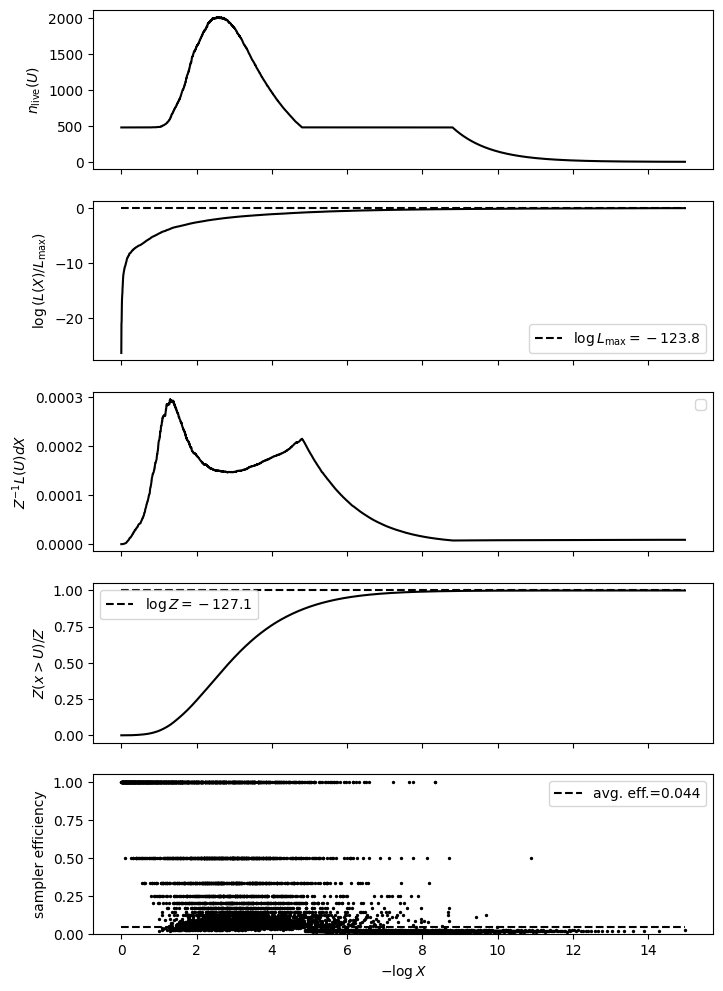

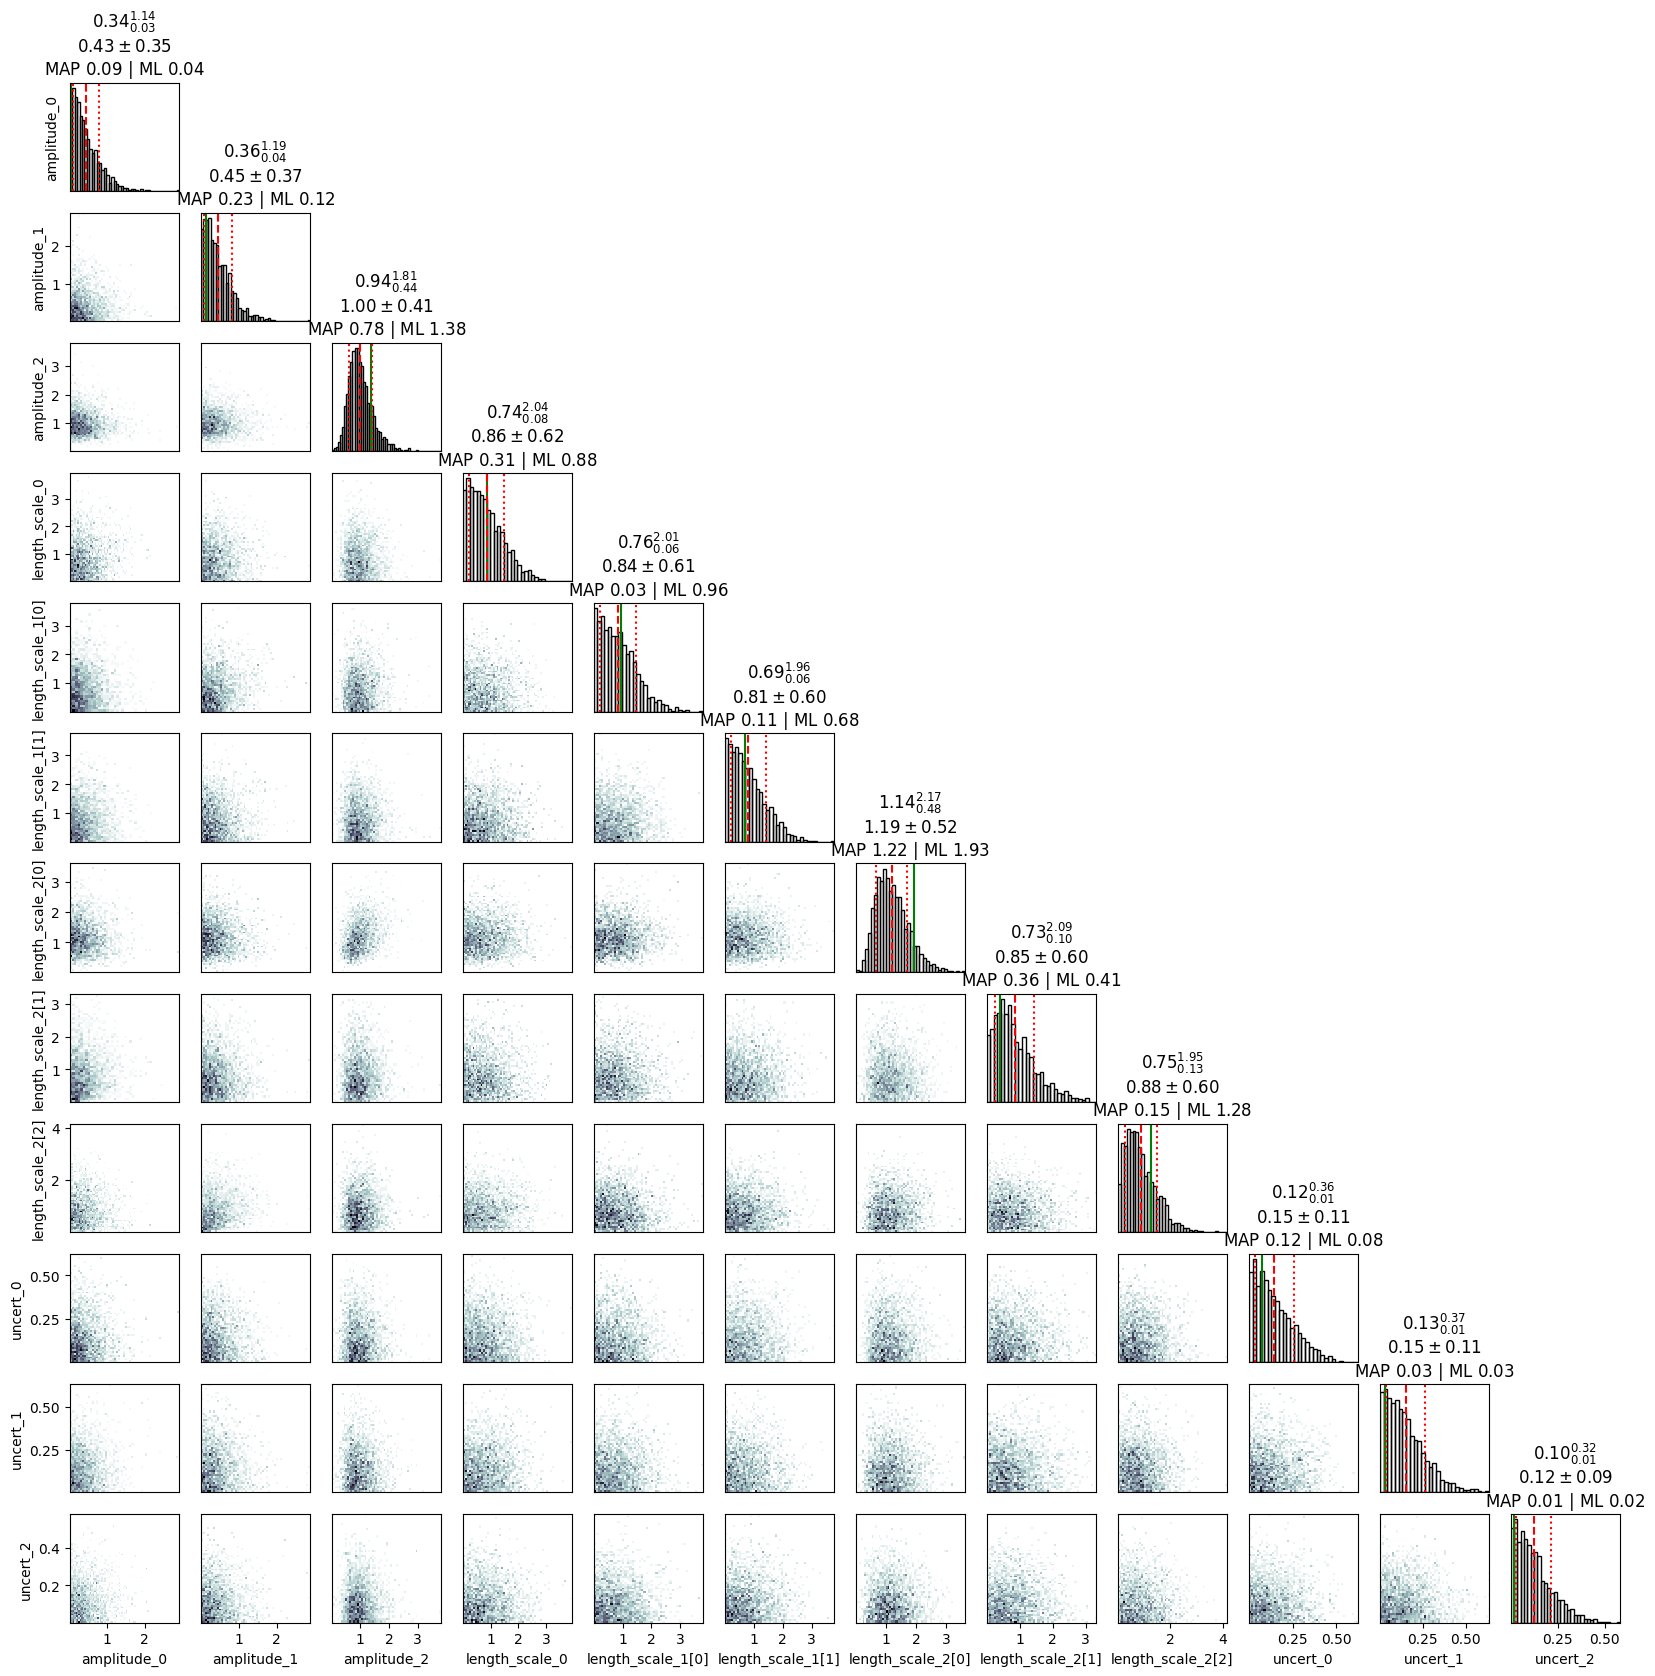

In [5]:
gpar = GPAR(X=x_obs[:, None], Y=y_obs, Y_var=jnp.ones_like(y_obs))

gpar.model.sanity_check(random.PRNGKey(0), S=100)

# Create the nested sampler class. In this case without any tuning.
exact_ns = ApproximateNestedSampler(model=gpar.model,
                                    num_live_points=gpar.model.U_ndims * 40,
                                    max_samples=1e6,
                                    num_parallel_samplers=1)

termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-5))
results = exact_ns.to_results(state, termination_reason)

exact_ns.summary(results)
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)


In [7]:

from jaxns.utils import marginalise_static_from_U


def predict_f_fn(uncerts: List[jnp.ndarray], kernel_params: List[Dict[str, jnp.ndarray]]):
    return gpar.predict_f(Xstar=x[:, None], uncerts=uncerts, kernel_params=kernel_params)


post_mean, post_var = marginalise_static_from_U(
    key=random.PRNGKey(42),
    U_samples=results.U_samples,
    model=gpar.model,
    log_weights=results.log_dp_mean,
    ESS=int(results.ESS), fun=predict_f_fn
)

# Plot posterior
for i in range(3):
    plt.plot(x, f[:, i], label='f{}'.format(i))
    plt.scatter(x_obs, y_obs[:, i], label='y{}'.format(i))
    plt.plot(x, post_mean[:, i], label='post_mean{}'.format(i))
    plt.plot(x, post_mean[:, i] + jnp.sqrt(post_var[:, i]), ls='dotted', c='black')
    plt.plot(x, post_mean[:, i] - jnp.sqrt(post_var[:, i]), ls='dotted', c='black')
    plt.legend()
    plt.show()


TypeError: prepare_func_args.<locals>._f() takes 0 positional arguments but 2 were given